<a href="https://colab.research.google.com/github/Danuragtiwari/goindiastock_assignmnt/blob/main/goindiastock_assignmnt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import ssl
from urllib.request import urlopen
from bs4 import BeautifulSoup as soup
from wordcloud import WordCloud
import configparser
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification
# from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

# Load sentiment analysis pipeline

sentiment_pipeline = pipeline("sentiment-analysis")
def get_ner(exp):
  return nlp(exp)


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [37]:
columns = ['Date of news','news headline','source of news']
google_url="https://news.google.com/rss/search?q=green%20hydrogen&hl=en-IN&gl=IN&ceid=IN:en"
def get_ner_entities(text):
    return ner_pipeline(text)

# Function to fetch news from Google News RSS feed
def google_news(xml_news_url):
    google_data = []
    org_data=[]

    context = ssl._create_unverified_context()
    Client = urlopen(xml_news_url, context=context)
    xml_page = Client.read()
    Client.close()

    soup_page = soup(xml_page, "xml")
    news_list = soup_page.findAll("item")

    for news in news_list:
        pub_date = news.pubDate.text
        headline = news.title.text
        source = news.link.text

        # Perform NER on the headline

        ner_entities = get_ner_entities(headline)

        # Extract organization names from NER entities

        organizations = [entity['word'] for entity in ner_entities if entity['entity'] == 'I-ORG']

        google_data.append([pub_date, headline, source, organizations])
        org_data.extend(organizations)

    columns = ['Date of news', 'News Headline', 'Source of news', 'Organizations']
    google_df = pd.DataFrame(google_data, columns=columns)

    return google_df

def org_data(xml_news_url):
    orgdata = []

    context = ssl._create_unverified_context()
    Client = urlopen(xml_news_url, context=context)
    xml_page = Client.read()
    Client.close()

    soup_page = soup(xml_page, "xml")
    news_list = soup_page.findAll("item")

    for news in news_list:
        pub_date = news.pubDate.text
        headline = news.title.text

        # Perform NER on the headline
        ner_entities = get_ner_entities(headline)

        # Extract organization names from NER entities
        organizations = [entity['word'] for entity in ner_entities if entity['entity'] == 'I-ORG']

        orgdata.extend(organizations)

    return orgdata

In [ ]:
def sentiment_analysis(data):

  l,l1=[],[]

  for i in data['News Headline']:
    l+=[sentiment_pipeline(i)[0]['label']] # Here sentiment_pipeline(i) = {['label':'POSITIVE','score':0.99915]}
    l1+=[sentiment_pipeline(i)[0]['score']]

  data['label'] = l
  data['score'] = l1

  return data


# result=google_news(google_url)
# print(result)
# Get news data from Google News
result = google_news(google_url)

# Perform sentiment analysis on the news headlines
result = sentiment_analysis(result)
result['Date of news'] = pd.to_datetime(result['Date of news'])

# Extract the week from the date
result['Week'] = result['Date of news'].dt.to_period("W-SUN")
# print(result)
# weekly_avg_sentiment
# plt.figure(figsize=(10, 6))
# plt.plot(weekly_avg_sentiment ['Week'], weekly_avg_sentiment ['score'], marker='o')
# plt.title('Week-wise Trend of Average Sentiment Score')
# plt.xlabel('Week')
# plt.ylabel('Average Sentiment Score')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.show()


result

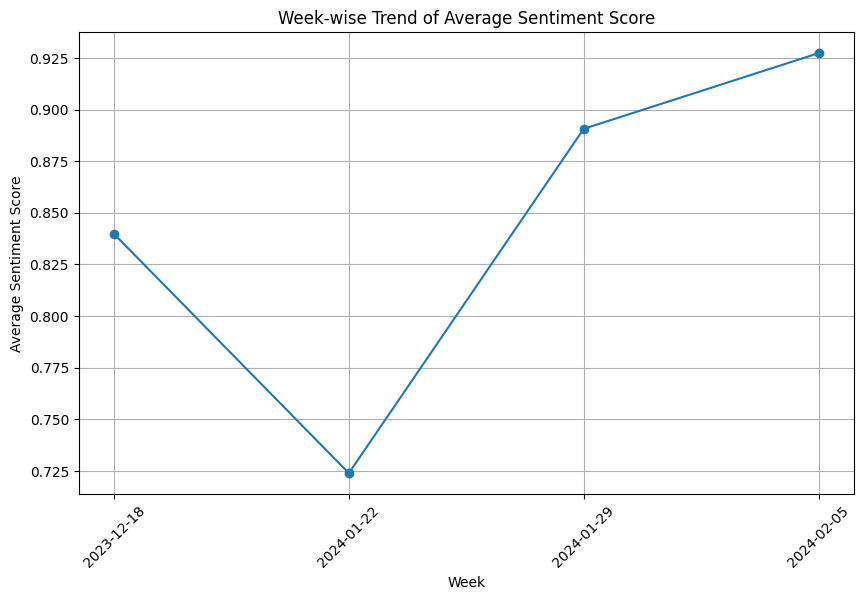

In [30]:

import matplotlib.pyplot as plt
# Group by week and calculate the average sentiment score
weekly_avg_sentiment = result.groupby('Week')['score'].mean().reset_index()
weekly_avg_sentiment['Week'] = weekly_avg_sentiment['Week'].apply(lambda x: x.start_time.strftime('%Y-%m-%d'))
plt.figure(figsize=(10, 6))

plt.plot(weekly_avg_sentiment ['Week'], weekly_avg_sentiment ['score'], marker='o')
plt.title('Week-wise Trend of Average Sentiment Score')
plt.xlabel('Week')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Word cloud map with organization name identified in the News**

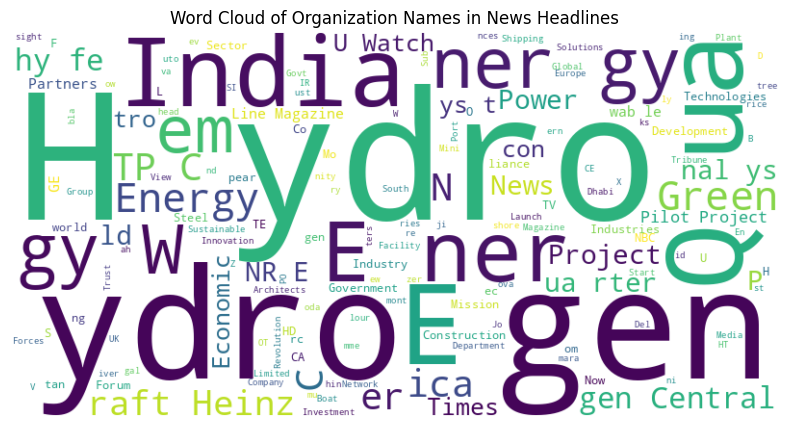

In [39]:
# Get organisation details!
orgdata=org_data(google_url)
# print(orgdata)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(orgdata))

# Plot Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Organization Names in News Headlines')
plt.show()